# Cumulative flow

Surface flow algorithms rely on the interconnection of nodes to pass information from one node to another in a downhill direction. Some algorithms include multiple downhill pathways where information is passed from a parent node to more than one downhill neighbours. Flow is split among $N$ downhill neighbours using

$$
\frac{Q_i}{Q_{\mathrm{total}}} = \frac{S_i^\alpha}{\sum_{i=1}^{N} S_i^{\alpha}}
$$

where $Q_{\mathrm{total}}$ is the total water discharge flowing through the node, $Q_i$ is the discharge into the immediate downstream node, $i$, and $\alpha$ is a partitioning parameter (usually $\alpha=\frac{1}{2}$). This notebook explores the propagation of information to downstream areas using one or two pathways.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from quagmire import TopoMesh # all routines we need are within this class
from quagmire import tools as meshtools

In [2]:
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0

x, y, bmask, = meshtools.elliptical_mesh(minX, maxX, minY, maxY, 0.05, 0.05, samples=100000, boundary_samples=1500)
x, y = meshtools.lloyd_mesh_improvment(x, y, bmask, iterations=5)
height = np.exp(-0.025*(x**2 + y**2)**2) + 0.0001

dm = meshtools.create_DMPlex_from_points(x, y, bmask)

mesh = TopoMesh(dm)
mesh.update_height(height)

Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0
 - Delaunay triangulation 1.28524s
 - Compute edge lengths 0.180773s
 - Construct neighbour array 0.71612s
 - Find boundaries 0.799566s
 - Build smoothing matrix 0.362245s
 - Sort nodes by field 0.210246s
 - Build downhill matrices 0.949245s


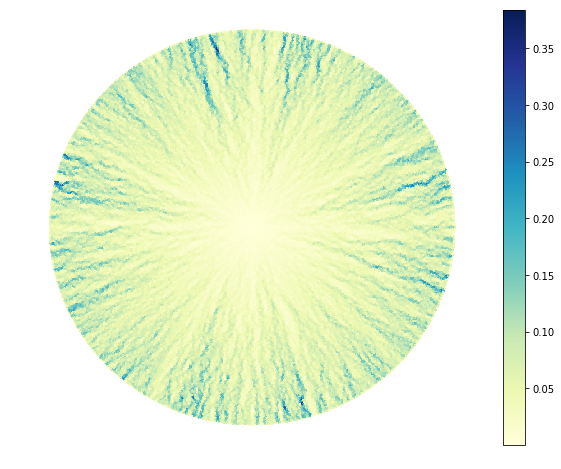

In [3]:
upstream_area = mesh.cumulative_flow(mesh.area)

fig = plt.figure(1, figsize=(10,8))
ax1 = fig.add_subplot(111)
ax1.axis('off')
im1 = ax1.tripcolor(x, y, mesh.tri.simplices, upstream_area, cmap='YlGnBu')
fig.colorbar(im1)
plt.show()

The plot above shows how the area is accumulated downstream (2 neighbours - default). The largest quantity is found at the edges of the domain where the streams are longest.

## One downhill neighbour

The `downhillMat` matrix houses the downstream neighbour network. It is the (weighted) sum of two matrices `adjacency1` and `adjacency2` which contain the first and second neighbours respectively. Below we replace `downhillMat` with `adjacency1`.

In [4]:
adjacency1 = mesh._build_adjacency_matrix_1()
mesh.downhillMat = mesh.adjacency1

In [5]:
import matplotlib.animation as manimation
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
        comment='Movie support!')
writer = FFMpegWriter(fps=24, codec='libx264', bitrate=2000, metadata=metadata)


DX0 = mesh.gvec.duplicate()
DX1 = mesh.gvec.duplicate()
DX1.set(1.0)

plt.ion()
fig = plt.figure(1, figsize=(5,5))
ax1 = fig.add_subplot(111, xlim=[minX,maxX], ylim=[minY,maxY])
ax1.axes.set_aspect("equal")
ax1.axis('off')
ax1.triplot(x, y, mesh.tri.simplices, color="Black", linewidth=0.1, alpha=0.5, zorder=0)
im1 = ax1.tripcolor(x, y, mesh.tri.simplices, DX1.array, vmin=0, vmax=1, cmap='YlOrRd', shading='gouraud', alpha=0.5, zorder=1)

step=0
with writer.saving(fig, 'sombrero_1n.mp4', 100):
    while DX1.array.any() and step < 250: 
                
        im1.set_array(DX1.array)
        fig.canvas.draw()
        writer.grab_frame()

        if step%10 == 0:
            print "step {:05d} -  remaining information  {:.3f}".format(step, DX1.sum())

        step += 1

        DX1 = mesh.downhillMat*DX1
        DX0 += DX1
        
plt.close()

step 00000 -  remaining information  82832.000
step 00010 -  remaining information  69306.000
step 00020 -  remaining information  59671.000
step 00030 -  remaining information  50746.000
step 00040 -  remaining information  42608.000
step 00050 -  remaining information  35109.000
step 00060 -  remaining information  28327.000
step 00070 -  remaining information  22289.000
step 00080 -  remaining information  16944.000
step 00090 -  remaining information  12317.000
step 00100 -  remaining information  8407.000
step 00110 -  remaining information  5238.000
step 00120 -  remaining information  2813.000
step 00130 -  remaining information  1132.000
step 00140 -  remaining information  215.000
step 00150 -  remaining information  14.000


## Two downhill neighbours

This is the default setting in Quagmire. It uses the partitioning algorithm above to split information among downhill neighbours. If there is only one downhill neighbour then all the flow is directed to that node.

In [6]:
mesh._build_downhill_matrix()

In [7]:
DX0 = mesh.gvec.duplicate()
DX1 = mesh.gvec.duplicate()
DX1.set(1.0)

plt.ion()
fig = plt.figure(1, figsize=(5,5))
ax1 = fig.add_subplot(111, xlim=[minX,maxX], ylim=[minY,maxY])
ax1.axes.set_aspect("equal")
ax1.axis('off')
ax1.triplot(x, y, mesh.tri.simplices, color="Black", linewidth=0.1, alpha=0.5, zorder=0)
im1 = ax1.tripcolor(x, y, mesh.tri.simplices, DX1.array, vmin=0, vmax=1, cmap='YlOrRd', shading='gouraud', alpha=0.5, zorder=1)

step=0
with writer.saving(fig, 'sombrero_2n.mp4', 100):
    while DX1.array.any() and step < 250: 
                
        im1.set_array(DX1.array)
        fig.canvas.draw()
        writer.grab_frame()

        if step%10 == 0:
            print "step {:05d} -  remaining information  {:.3f}".format(step, DX1.sum())

        step += 1

        DX1 = mesh.downhillMat*DX1
        DX0 += DX1
        
plt.close()

step 00000 -  remaining information  82832.000
step 00010 -  remaining information  70577.447
step 00020 -  remaining information  62386.474
step 00030 -  remaining information  54665.235
step 00040 -  remaining information  47432.546
step 00050 -  remaining information  40707.970
step 00060 -  remaining information  34487.967
step 00070 -  remaining information  28777.295
step 00080 -  remaining information  23563.138
step 00090 -  remaining information  18881.844
step 00100 -  remaining information  14709.625
step 00110 -  remaining information  11052.551
step 00120 -  remaining information  7925.660
step 00130 -  remaining information  5322.428
step 00140 -  remaining information  3241.259
step 00150 -  remaining information  1670.117
step 00160 -  remaining information  615.015
step 00170 -  remaining information  95.456
step 00180 -  remaining information  1.384
step 00190 -  remaining information  0.000
step 00200 -  remaining information  0.000
step 00210 -  remaining informatio

## $N$ downhill neighbours

Now we split flow into all downhill neighbours. There may be several recipient nodes that are lower than the parent node depending on the unstructured mesh.

In [8]:
mesh._build_downhill_matrix_neighbours()

In [9]:
DX0 = mesh.gvec.duplicate()
DX1 = mesh.gvec.duplicate()
DX1.set(1.0)

plt.ion()
fig = plt.figure(1, figsize=(5,5))
ax1 = fig.add_subplot(111, xlim=[minX,maxX], ylim=[minY,maxY])
ax1.axes.set_aspect("equal")
ax1.axis('off')
ax1.triplot(x, y, mesh.tri.simplices, color="Black", linewidth=0.1, alpha=0.5, zorder=0)
im1 = ax1.tripcolor(x, y, mesh.tri.simplices, DX1.array, vmin=0, vmax=1, cmap='YlOrRd', shading='gouraud', alpha=0.5, zorder=1)

step=0
with writer.saving(fig, 'sombrero_Nn.mp4', 100):
    while DX1.array.any() and step < 250: 
                
        im1.set_array(DX1.array)
        fig.canvas.draw()
        writer.grab_frame()

        if step%10 == 0:
            print "step {:05d} -  remaining information  {:.3f}".format(step, DX1.sum())

        step += 1

        DX1 = mesh.downhillMat*DX1
        DX0 += DX1

plt.close()

step 00000 -  remaining information  82832.000
step 00010 -  remaining information  74841.631
step 00020 -  remaining information  69982.333
step 00030 -  remaining information  65292.910
step 00040 -  remaining information  60742.770
step 00050 -  remaining information  56337.289
step 00060 -  remaining information  52070.378
step 00070 -  remaining information  47949.357
step 00080 -  remaining information  43981.275
step 00090 -  remaining information  40174.057
step 00100 -  remaining information  36528.488
step 00110 -  remaining information  33046.886
step 00120 -  remaining information  29736.915
step 00130 -  remaining information  26592.951
step 00140 -  remaining information  23616.773
step 00150 -  remaining information  20814.230
step 00160 -  remaining information  18185.628
step 00170 -  remaining information  15731.178
step 00180 -  remaining information  13451.872
step 00190 -  remaining information  11348.230
step 00200 -  remaining information  9422.213
step 00210 -  

The number of iterations to propogate information out of the domain increases with the number of downhill neighbours. One downhill neighbour is the fastest, yet the least realistic. Two downhill neighbours offers a good compromise between realistic flow and computation time.